<a href="https://colab.research.google.com/github/J-A-S-H-U/Hardware_for_AI_ML/blob/main/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%%writefile feedforward.cu
#include <iostream>
#include <cuda_runtime.h>
#include <curand.h>
#include <curand_kernel.h>

#define INPUT_SIZE 4
#define HIDDEN_SIZE 5
#define OUTPUT_SIZE 1

__global__ void feedforward(float *input, float *W1, float *b1, float *W2, float *b2, float *output) {
    // Hidden layer
    int tid = threadIdx.x;
    if (tid < HIDDEN_SIZE) {
        float sum = 0.0f;
        for (int i = 0; i < INPUT_SIZE; i++) {
            sum += input[i] * W1[i * HIDDEN_SIZE + tid];
        }
        sum += b1[tid];
        // Simple ReLU activation
        output[tid] = fmaxf(0.0f, sum);
    }
    __syncthreads();

    // Output layer (1 output neuron, use tid=0)
    if (tid == 0) {
        float sum = 0.0f;
        for (int i = 0; i < HIDDEN_SIZE; i++) {
            sum += output[i] * W2[i];
        }
        sum += b2[0];
        output[0] = sum;
    }
}

int main() {
    float h_input[INPUT_SIZE] = {1.0f, 0.5f, -1.0f, 2.0f};
    float h_W1[INPUT_SIZE * HIDDEN_SIZE];
    float h_b1[HIDDEN_SIZE];
    float h_W2[HIDDEN_SIZE];
    float h_b2[1] = {0.1f};
    float h_output[HIDDEN_SIZE];  // reuse for both hidden and output

    // Initialize weights
    for (int i = 0; i < INPUT_SIZE * HIDDEN_SIZE; i++) h_W1[i] = 0.1f;
    for (int i = 0; i < HIDDEN_SIZE; i++) h_b1[i] = 0.1f;
    for (int i = 0; i < HIDDEN_SIZE; i++) h_W2[i] = 0.1f;

    // Device memory
    float *d_input, *d_W1, *d_b1, *d_W2, *d_b2, *d_output;
    cudaMalloc((void**)&d_input, INPUT_SIZE * sizeof(float));
    cudaMalloc((void**)&d_W1, INPUT_SIZE * HIDDEN_SIZE * sizeof(float));
    cudaMalloc((void**)&d_b1, HIDDEN_SIZE * sizeof(float));
    cudaMalloc((void**)&d_W2, HIDDEN_SIZE * sizeof(float));
    cudaMalloc((void**)&d_b2, sizeof(float));
    cudaMalloc((void**)&d_output, HIDDEN_SIZE * sizeof(float)); // reused for final output

    // Copy to device
    cudaMemcpy(d_input, h_input, INPUT_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_W1, h_W1, INPUT_SIZE * HIDDEN_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b1, h_b1, HIDDEN_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_W2, h_W2, HIDDEN_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b2, h_b2, sizeof(float), cudaMemcpyHostToDevice);

    // Launch kernel
    feedforward<<<1, HIDDEN_SIZE>>>(d_input, d_W1, d_b1, d_W2, d_b2, d_output);

    // Copy back result
    cudaMemcpy(h_output, d_output, sizeof(float), cudaMemcpyDeviceToHost);
    std::cout << "Output: " << h_output[0] << std::endl;

    cudaFree(d_input); cudaFree(d_W1); cudaFree(d_b1); cudaFree(d_W2); cudaFree(d_b2); cudaFree(d_output);
    return 0;
}


Overwriting feedforward.cu


CUDA VERSION

In [2]:
!nvcc feedforward.cu -o feedforward
!./feedforward

Output: 0


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the fixed input (like in CUDA code)
input_tensor = torch.tensor([1.0, 0.5, -1.0, 2.0])

# Define fixed weights and biases (all 0.1 like in CUDA)
W1 = torch.full((4, 5), 0.1)     # shape: [input_size, hidden_size]
b1 = torch.full((5,), 0.1)       # shape: [hidden_size]
W2 = torch.full((5,), 0.1)       # shape: [hidden_size]
b2 = torch.tensor(0.1)           # scalar bias

# Forward pass manually
# Hidden layer computation
hidden = torch.matmul(input_tensor, W1) + b1
hidden = F.relu(hidden)

# Output layer computation
output = torch.dot(hidden, W2) + b2

# Print final output
print("Output:", output.item())


Output: 0.2750000059604645


PyTorch Version

In [9]:
%%writefile feedforward.cu

#include <iostream>
#include <cuda_runtime.h>

#define INPUT_SIZE 4
#define HIDDEN_SIZE 5
#define OUTPUT_SIZE 1

__global__ void feedforward(float *input, float *W1, float *b1, float *W2, float *b2, float *output) {
    int tid = threadIdx.x;
    if (tid < HIDDEN_SIZE) {
        float sum = 0.0f;
        for (int i = 0; i < INPUT_SIZE; i++) {
            sum += input[i] * W1[i * HIDDEN_SIZE + tid];
        }
        sum += b1[tid];
        output[tid] = fmaxf(0.0f, sum);
    }
    __syncthreads();

    if (tid == 0) {
        float sum = 0.0f;
        for (int i = 0; i < HIDDEN_SIZE; i++) {
            sum += output[i] * W2[i];
        }
        sum += b2[0];
        output[0] = sum;
    }
}

int main() {
    float h_input[INPUT_SIZE] = {1.0f, 0.5f, -1.0f, 2.0f};
    float h_W1[INPUT_SIZE * HIDDEN_SIZE];
    float h_b1[HIDDEN_SIZE];
    float h_W2[HIDDEN_SIZE];
    float h_b2[1] = {0.1f};
    float h_output[HIDDEN_SIZE];

    for (int i = 0; i < INPUT_SIZE * HIDDEN_SIZE; i++) h_W1[i] = 0.1f;
    for (int i = 0; i < HIDDEN_SIZE; i++) h_b1[i] = 0.1f;
    for (int i = 0; i < HIDDEN_SIZE; i++) h_W2[i] = 0.1f;

    float *d_input, *d_W1, *d_b1, *d_W2, *d_b2, *d_output;
    cudaMalloc((void**)&d_input, INPUT_SIZE * sizeof(float));
    cudaMalloc((void**)&d_W1, INPUT_SIZE * HIDDEN_SIZE * sizeof(float));
    cudaMalloc((void**)&d_b1, HIDDEN_SIZE * sizeof(float));
    cudaMalloc((void**)&d_W2, HIDDEN_SIZE * sizeof(float));
    cudaMalloc((void**)&d_b2, sizeof(float));
    cudaMalloc((void**)&d_output, HIDDEN_SIZE * sizeof(float));

    cudaMemcpy(d_input, h_input, INPUT_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_W1, h_W1, INPUT_SIZE * HIDDEN_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b1, h_b1, HIDDEN_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_W2, h_W2, HIDDEN_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b2, h_b2, sizeof(float), cudaMemcpyHostToDevice);

    // Measure memory usage before kernel execution
    size_t free_mem_before, total_mem;
    cudaMemGetInfo(&free_mem_before, &total_mem);

    // Measure execution time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start, 0);

    feedforward<<<1, HIDDEN_SIZE>>>(d_input, d_W1, d_b1, d_W2, d_b2, d_output);

    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);

    // Measure memory usage after kernel execution
    size_t free_mem_after;
    cudaMemGetInfo(&free_mem_after, &total_mem);

    float h_result;
    cudaMemcpy(&h_result, d_output, sizeof(float), cudaMemcpyDeviceToHost);
    std::cout << "Output: " << h_result << std::endl;
    std::cout << "Kernel execution time: " << milliseconds << " ms" << std::endl;
    std::cout << "GPU memory used: " << (free_mem_before - free_mem_after) / (1024.0 * 1024.0) << " MB" << std::endl;

    cudaFree(d_input); cudaFree(d_W1); cudaFree(d_b1);
    cudaFree(d_W2); cudaFree(d_b2); cudaFree(d_output);
    cudaEventDestroy(start); cudaEventDestroy(stop);
    return 0;
}


Overwriting feedforward.cu


In [11]:
!nvcc feedforward.cu -o feedforward
!./feedforward

feedforward.cu(37): warning #177-D: variable "h_output" was declared but never referenced
      float h_output[5];
            ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

Output: 0
Kernel execution time: 7.57187 ms
GPU memory used: 0 MB


Benchmarking the CUDA Code

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

# Define the fixed input (as in the CUDA code)
input_tensor = torch.tensor([1.0, 0.5, -1.0, 2.0])

# Define fixed weights and biases (all 0.1 as in the CUDA code)
W1 = torch.full((4, 5), 0.1)     # shape: [input_size, hidden_size]
b1 = torch.full((5,), 0.1)       # shape: [hidden_size]
W2 = torch.full((5,), 0.1)       # shape: [hidden_size]
b2 = torch.tensor(0.1)           # scalar bias

# Move tensors to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

# Warm-up iterations
for _ in range(10):
    hidden = torch.matmul(input_tensor, W1) + b1
    hidden = F.relu(hidden)
    output = torch.dot(hidden, W2) + b2

# Benchmarking
torch.cuda.reset_peak_memory_stats(device)
start_time = time.time()
hidden = torch.matmul(input_tensor, W1) + b1
hidden = F.relu(hidden)
output = torch.dot(hidden, W2) + b2
torch.cuda.synchronize()  # Ensure all CUDA operations are complete
end_time = time.time()

# Retrieve peak memory usage
peak_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # Convert bytes to MB

# Print results
print(f"Output: {output.item()}")
print(f"Execution Time: {(end_time - start_time) * 1000:.6f} ms")
print(f"Peak Memory Usage: {peak_memory:.6f} MB")


Output: 0.2750000059604645
Execution Time: 0.452757 ms
Peak Memory Usage: 8.129395 MB


Benchmarking PyTorch Code

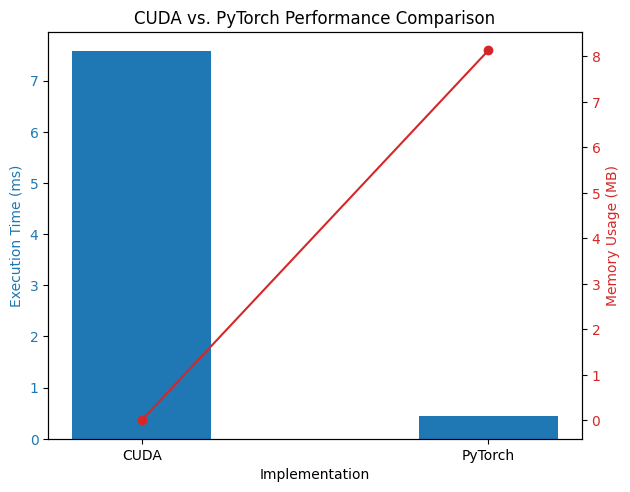

In [15]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual measurements)
implementations = ['CUDA', 'PyTorch']
execution_times = [7.57187, 0.452757]  # Replace with actual values
memory_usages = [0, 8.129395]  # Replace with actual values

x = range(len(implementations))

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Implementation')
ax1.set_ylabel('Execution Time (ms)', color=color)
ax1.bar(x, execution_times, color=color, width=0.4, align='center', label='Execution Time')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(implementations)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Memory Usage (MB)', color=color)
ax2.plot(x, memory_usages, color=color, marker='o', label='Memory Usage')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('CUDA vs. PyTorch Performance Comparison')
plt.show()